In [10]:
from pathlib import Path

# Read all muse files in the provided source directory
# Inspired by: https://www.reddit.com/r/learnpython/comments/1eiki68/comment/lg89efe/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button
src = Path("../samples/calibration-imu-blinks/")
target = "muse.csv"
muses = [file for file in src.rglob(target)]
for f in muses: print(f)

..\samples\calibration-imu-blinks\PIa\1.device=android-vr=off-eeg=off-distance=close\muse.csv
..\samples\calibration-imu-blinks\PIa\10.device=ios-vr=quit-eeg=on-distance=close\muse.csv
..\samples\calibration-imu-blinks\PIa\11.device=android-vr=quit-eeg=on-distance=far\muse.csv
..\samples\calibration-imu-blinks\PIa\12.device=ios-vr=quit-eeg=on-distance=far\muse.csv
..\samples\calibration-imu-blinks\PIa\13.device=android-vr=off-eeg=on-distance=close\muse.csv
..\samples\calibration-imu-blinks\PIa\14.device=ios-vr=off-eeg=on-distance=close\muse.csv
..\samples\calibration-imu-blinks\PIa\15.device=android-vr=off-eeg=on-distance=far\muse.csv
..\samples\calibration-imu-blinks\PIa\16.device=ios-vr=off-eeg=on-distance=far\muse.csv
..\samples\calibration-imu-blinks\PIa\2.device=ios-vr=off-eeg=off-distance=close\muse.csv
..\samples\calibration-imu-blinks\PIa\3.device=android-vr=off-eeg=off-distance=far\muse.csv
..\samples\calibration-imu-blinks\PIa\4.device=ios-vr=off-eeg=off-distance=far\muse.csv

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime
from matplotlib.gridspec import GridSpecFromSubplotSpec


_REMAPPINGS = { 'RAW_TP9':'TP9', 
                'RAW_TP10':'TP10', 
                'RAW_AF7':'AF7', 
                'RAW_AF8':'AF8', 
                'Accelerometer_X':'accel_x', 
                'Accelerometer_Y':'accel_y', 
                'Accelerometer_Z':'accel_z', 
                'Gyro_X':'gyro_x', 
                'Gyro_Y':'gyro_y',
                'Gyro_Z':'gyro_z'   }
_RAW = [    'TP9', 'TP10', 'AF7', 'AF8'  ]
_IMU = [    'accel_x', 'accel_y', 'accel_z', 'gyro_x',  'gyro_y', 'gyro_z' ]
_PRO = [    'Delta_TP9','Delta_TP10','Delta_AF7','Delta_AF8',
            'Theta_TP9', 'Theta_TP10', 'Theta_AF7', 'Theta_AF8', 
            'Alpha_TP9', 'Alpha_TP10', 'Alpha_AF7', 'Alpha_AF8',
            'Beta_TP9', 'Beta_TP10', 'Beta_AF7', 'Beta_AF8',
            'Gamma_TP9', 'Gamma_TP10', 'Gamma_AF7', 'Gamma_AF8'     ]
_COLORS = { 'TP9': 'red', 
            'TP10': 'blue',
            'AF7': 'orange',
            'AF8': 'lightblue',
            'accel_x':'blue',
            'accel_y':'red',
            'accel_z':'orange',
            'gyro_x':'blue',
            'gyro_y':'red',
            'gyro_z':'orange'   }

# Read each file as a Pandas DataFrame
class Muse:
    def __init__(self, src:str):
        # Cache src file
        self.src = src
        # Read DF
        df = pd.read_csv(src, dtype={'Elements':str})
        df['unix_ms'] = df['TimeStamp'].apply(self.timestamp_to_unix_milliseconds)
        df = df.rename(columns=_REMAPPINGS)
        self.df = df.sort_values('unix_ms')
        # Separate signals
        self.signals = df[df['Elements'].isna()]
        # Identify components
        blinks = df[df['Elements']=='/muse/elements/blink']
        self.blinks = blinks[['TimeStamp', 'unix_ms']]
        self.raw = self.signals[['TimeStamp', 'unix_ms', *_RAW]]
        self.pro = self.signals[['TimeStamp', 'unix_ms', *_PRO]]
        self.imu = self.signals[['TimeStamp', 'unix_ms', *_IMU]]
    
    def plot_duplicates(self, parent_spec=None):
        # For each component, we measure consecutive dupes, count their frequency, and plot in the same column
        raw_dupes = self.get_consecutive_duplicates(self.raw, ['TimeStamp'])
        detailed_raw_dupes = self.get_consecutive_duplicates(self.raw, ['TimeStamp', 'TP9'])
        imu_dupes = self.get_consecutive_duplicates(self.imu, ['TimeStamp'])
        detailed_imu_dupes = self.get_consecutive_duplicates(self.imu, ['TimeStamp', 'gyro_y'])
        if parent_spec is not None:
            # If parent_spec is provided, then we are plotting in a matplotlib plot
            fig = parent_spec.get_gridspec().figure
            # raw eeg and IMU are split across two rows
            gs = GridSpecFromSubplotSpec(2, 1, subplot_spec=parent_spec, hspace=0.1)
            # plot
            ax1 = fig.add_subplot(gs[0])
            eeg = pd.concat([raw_dupes, detailed_raw_dupes], axis=1).fillna(0)
            eeg.columns = ['time', 'time+col']
            eeg.plot.bar(ax=ax1, width=0.8, edgecolor='black')
            ax1.legend()
            ax2 = fig.add_subplot(gs[1], sharex=ax1)
            imu = pd.concat([imu_dupes, detailed_imu_dupes], axis=1).fillna(0)
            imu.columns = ['time', 'time+col']
            imu.plot.bar(ax=ax2, width=0.8, edgecolor='black')
            ax2.legend()
            return
        print(os.path.basename(os.path.dirname(self.src)))
        print("\tOnly Time:", "\tEEG:", self.sparkline(raw_dupes), "\tIMU:", self.sparkline(imu_dupes))
        print("\tTime + Col:", "\tEEG", self.sparkline(detailed_raw_dupes), "\tIMU", self.sparkline(detailed_imu_dupes))
        
    @staticmethod
    def sparkline(values):
        ticks = "▁▂▃▄▅▆▇█"
        values = np.asarray(values, dtype=float)
        if values.max() == 0:   return ""
        scaled = (values - values.min()) / (values.max() - values.min())
        return "".join(ticks[int(v * (len(ticks) - 1))] for v in scaled)

    @staticmethod
    def get_consecutive_duplicates(df:pd.DataFrame, columns):
        change_mask = df[columns].ne(df[columns].shift()).any(axis=1)
        group_ids = change_mask.cumsum()
        df2 = df.assign(
            consecutive_count = df.groupby(group_ids).cumcount() + 1,
            block_size = df.groupby(group_ids)[columns[0]].transform('size')
        )
        dist = df2['block_size'].value_counts().sort_index()
        return dist

    @staticmethod
    def timestamp_to_unix_milliseconds(x) -> int:      # Helper: converts timestamps to unix
        date_format = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
        unix_seconds = datetime.datetime.timestamp(date_format)
        unix_milliseconds = int(unix_seconds * 1000)
        return unix_milliseconds

Index(['count', 'count'], dtype='object')             count    count
block_size                
1            2019  10324.0
2            4582    296.0
3            2673      0.0
4            1276      0.0
5              70      0.0
Index(['count', 'count'], dtype='object')             count    count
block_size                
1            8193  16021.0
2            7834    308.0
3             105      3.0
4             200      0.0
Index(['count', 'count'], dtype='object')             count    count
block_size                
1            7605  47071.0
2           22828   1448.0
3           16101     21.0
4            1720      0.0
5             280      0.0
6               6      0.0
Index(['count', 'count'], dtype='object')             count    count
block_size                
1           26431  48828.0
2           22756    672.0
3              93      0.0
4             220      0.0
Index(['count', 'count'], dtype='object')             count    count
block_size                
1      

KeyboardInterrupt: 

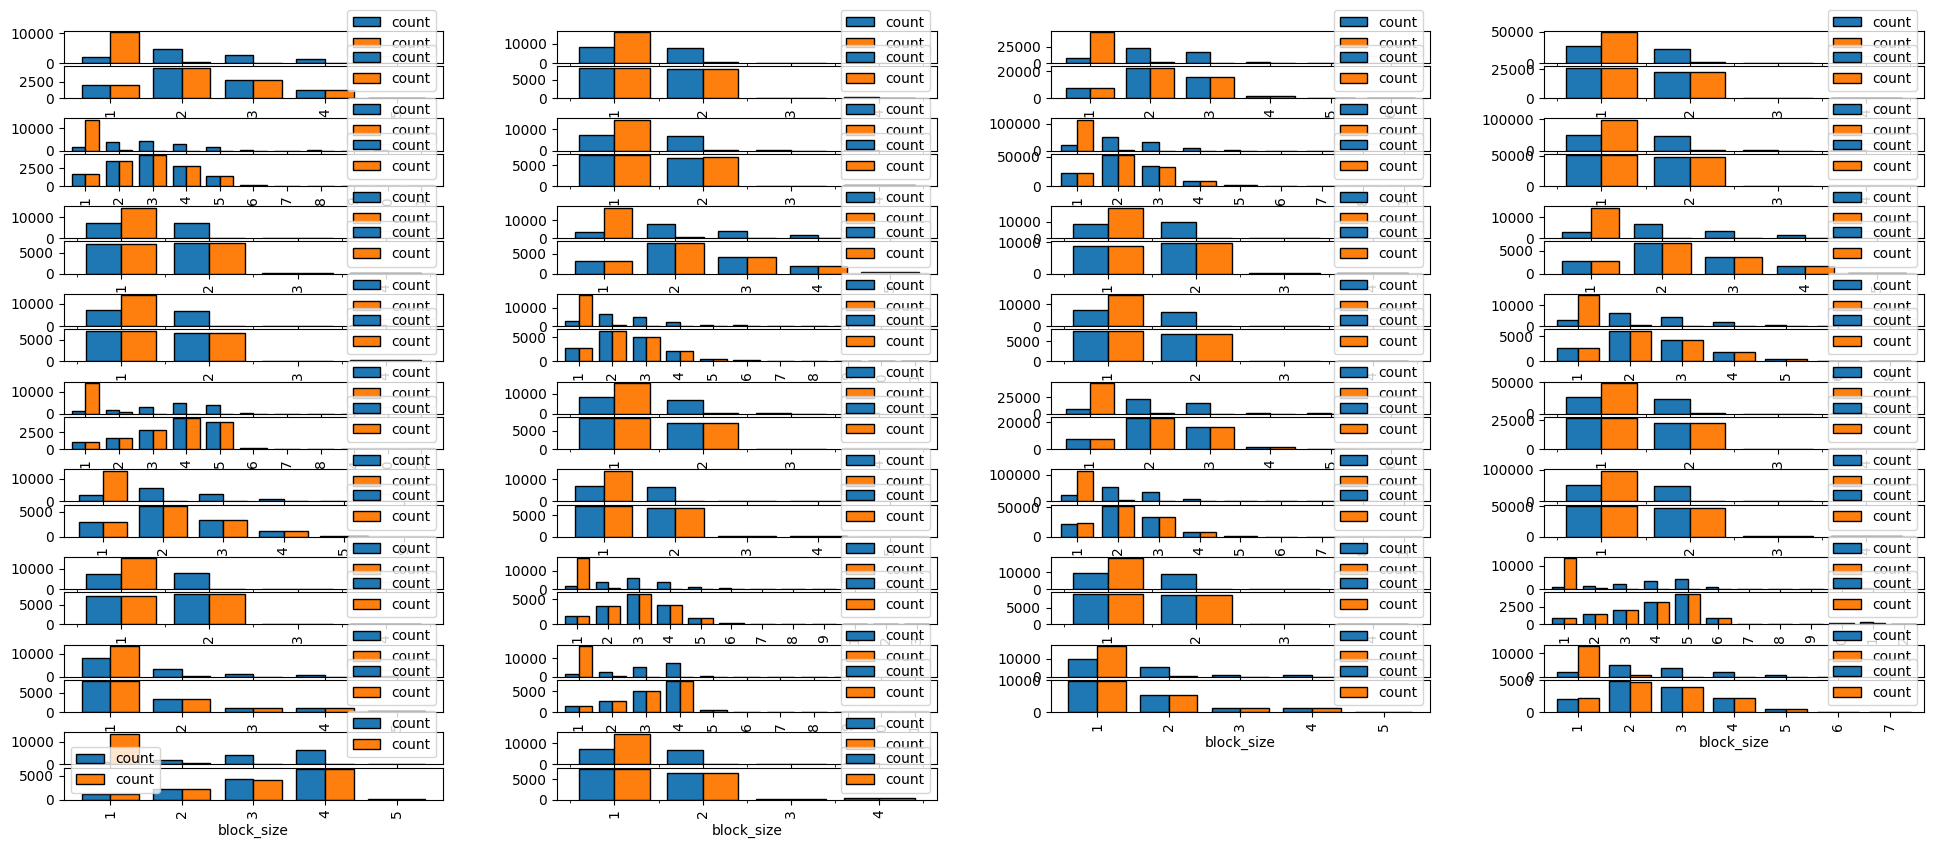

In [86]:
import math

NCOLS=4
NROWS = math.ceil(len(muses)/NCOLS)

fig = plt.figure(figsize=(NROWS*2, NCOLS*3), layout=None)
gs = fig.add_gridspec(NROWS, NCOLS, hspace=0.3, wspace=0.3, top=0.97)
for i, f in enumerate(muses):
    row_index = math.floor(i/NCOLS)
    col_index = i % NCOLS
    muse = Muse(f)
    muse.plot_duplicates(parent_spec=gs[row_index, col_index])
plt.show()


In [ ]:
import matplotlib.pyplot as plt